# Extended DMD with control for nonlinear systems
We demonstrate extended dynamic mode decomposition for control (EDMDc) applied to 

## classical forced Van der Pol oscillator
(this is example in Sec. 4 in Korda & Mezić, _"Linear predictors for nonlinear dynamical systems: Koopman operator meets model predictive control"_, Automatica 2018), with dynamics given by:

$$\dot{x}_{1} = 2x_2 u,\\
\dot{x}_2 = -0.8x_1 + 2x_2 -10x_1^2x_2 + u$$

In [1]:
%matplotlib inline
import pykoopman as pk
from pykoopman.common.examples import vdp_osc, rk4, square_wave  # required for example system
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility

import warnings
warnings.filterwarnings('ignore')

### Training data
A training dataset is created consisting of 200 trajectories, each trajectory is integrated for 1000 timesteps and forced by a random actuation in the range $[-1,1]$. Each trajectory starts at a random initial condition in the unit box $[-1,1]^2$.

In [2]:
n_states = 2 # Number of states
n_inputs = 1 # Number of control inputs
dT = 0.01    # Timestep
n_traj = 200  # Number of trajectories
n_int = 1000  # Integration length

In [3]:
# Time vector
t = np.arange(0, n_int*dT, dT)

# Uniform random distributed forcing in [-1, 1]
u = 2*rnd.random([n_int, n_traj])-1

# Uniform distribution of initial conditions
x = 2*rnd.random([n_states, n_traj])-1

# Init
X = np.zeros((n_states, n_int*n_traj))
Y = np.zeros((n_states, n_int*n_traj))
U = np.zeros((n_inputs, n_int*n_traj))

# Integrate
for step in range(n_int):
    y = rk4(0, x, u[step, :], dT, vdp_osc)
    X[:, (step)*n_traj:(step+1)*n_traj] = x
    Y[:, (step)*n_traj:(step+1)*n_traj] = y
    U[:, (step)*n_traj:(step+1)*n_traj] = u[step, :]
    x = y

[Text(0, 0.5, '$x_2$'), Text(0.5, 0, '$t$')]

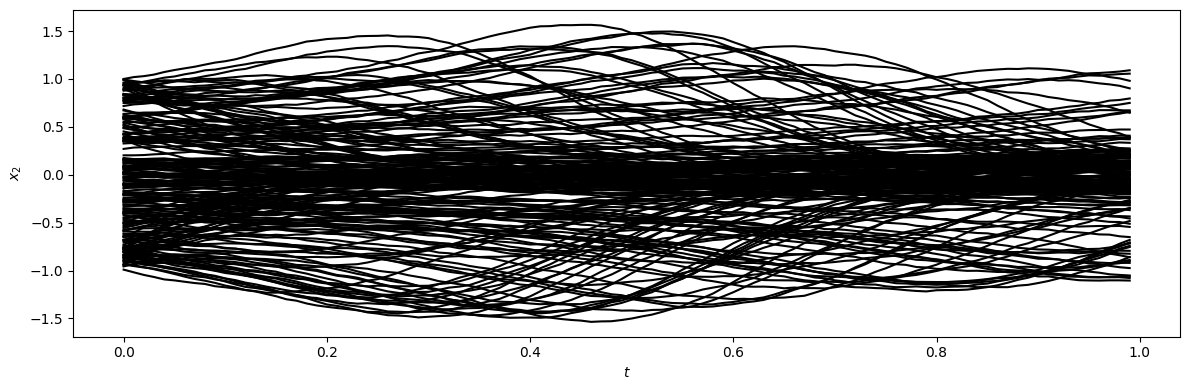

In [4]:
# Visualize first 100 steps of the training data
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
for traj_idx in range(n_traj):
    x = X[:, traj_idx::n_traj]
    axs.plot(t[0:100], x[1, 0:100], 'k')
axs.set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')

### EDMDc model
The observables (or lifting functions) for the Koopman model are chosen to be the state itself ($\psi_1 = x_1,\psi_2=x_2$) (by setting `include_states=True` below, which is also the default) and thin plate radial basis functions with centers selected randomly.

In [5]:
EDMDc = pk.regression.EDMDc()
RBF = pk.observables.RadialBasisFunction(rbf_type='thinplate', n_centers=10, centers=None, kernel_width=1.0, polyharmonic_coeff=1.0, include_state=True)

model = pk.Koopman(observables=RBF, regressor=EDMDc)
model.fit(X.T, y=Y.T, u=U.T)

Koopman(observables=RadialBasisFunction(centers=array([[-0.7712602 ,  0.08116391, -1.09928175, -0.4938513 , -0.94659796,
         0.2806932 ,  1.06131153, -1.10058965,  0.93620142,  0.62382521],
       [ 0.17825981,  1.56461218, -0.93088127, -1.5355701 ,  0.99751768,
        -1.26512792,  1.16563297,  1.45705332, -0.83537485,  1.26969393]]),
                                        rbf_type='thinplate'),
        regressor=EDMDc())

### Compare prediction accuracy of Koopman model on a test trajectory

In the following, the trained model is used to perform a multi-step prediction from a given initial condition. The prediction is compared with the true trajectory when integrating the nonlinear system.

In [6]:
n_int = 600  # Integration length
t = np.arange(0, n_int*dT, dT)
u = np.array([-square_wave(step+1) for step in range(n_int)])
x = np.array([0.5, 0.5])
# x = np.array([[-0.1], [-0.5]])

# Integrate nonlinear system
Xtrue = np.zeros((n_states, n_int))
Xtrue[:, 0] = x
for step in range(1, n_int, 1):
    y = rk4(0, Xtrue[:, step-1].reshape(n_states,1), u[np.newaxis, step-1], dT, vdp_osc)
    Xtrue[:, step] = y.reshape(n_states,)

Predict using Koopman model

In [7]:
# Multi-step prediction with Koopman/EDMDc model
Xkoop = model.simulate(x[np.newaxis,:], u[:, np.newaxis], n_steps=n_int-1)
Xkoop = np.vstack([x[np.newaxis,:], Xkoop]) # add initial condition to simulated data for comparison below

### Compare results

Text(0.5, 1.0, 'L2 norm error = 2.7272083525903112')

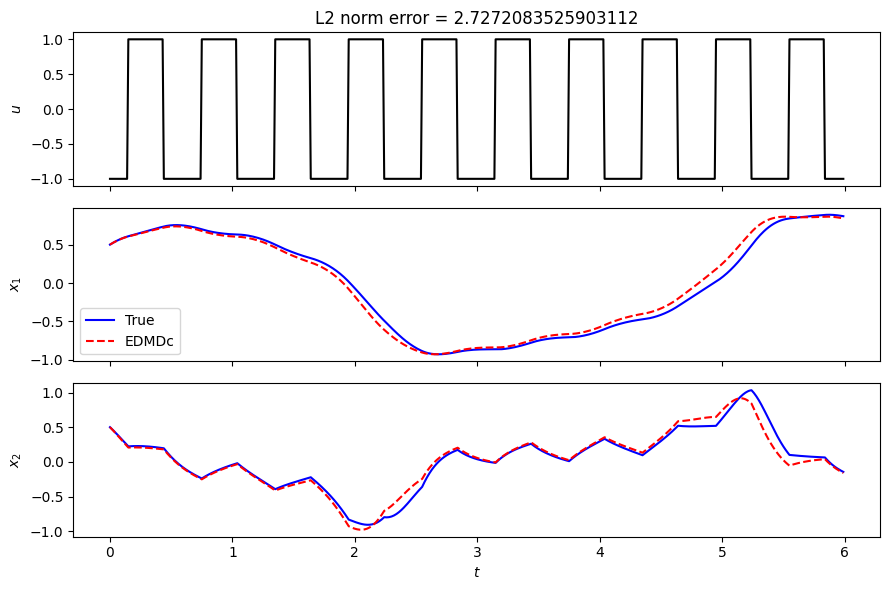

In [8]:
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(9, 6))
axs[0].plot(t, u, '-k')
axs[0].set(ylabel=r'$u$')
axs[1].plot(t, Xtrue[0, :], '-', color='b', label='True')
axs[1].plot(t, Xkoop[:, 0], '--r', label='EDMDc')
axs[1].set(ylabel=r'$x_1$')
axs[2].plot(t, Xtrue[1, :], '-', color='b', label='True')
axs[2].plot(t, Xkoop[:, 1], '--r', label='EDMDc')
axs[2].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')

axs[1].legend()

err = np.linalg.norm(Xtrue - Xkoop.T)
axs[0].set_title(f"L2 norm error = {err}")

## Result of system ID

$$
z^{+} = A z + B u\\
x = Cz
$$

In [9]:
model.A.shape

(12, 12)

In [10]:
model.B.shape

(12, 1)

In [11]:
model.C.shape

(2, 12)

In [13]:
model.W.shape

(2, 12)